# Testing Spatial.ai data vs QA variables for lift on 2020 sales & ticket model

In [1]:
#import sys
#!{sys.executable} -m pip install xlrd

In [1]:
import time
import math

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


# First we Format data coming from Sitewise

In [2]:
#Function that cleans data coming from Tetrad
def tetrad_df_cleaner(pop):
    #Dropping rows & cols that only consist of NANs and resetting index
    pop = pop.dropna(how="all", axis=0).dropna(how="all", axis=1).reset_index(drop=True)
    #Getting radii into the columns names
    prev=""
    for x in range(pop.shape[1]):
        if pd.isna(pop.iloc[0,x]):
            pop.iloc[1,x] = pop.iloc[1,x]+prev
        else:
            prev = " "+ pop.iloc[0,x]
            pop.iloc[1,x] = pop.iloc[1,x]+prev
    #dropping row of na & radii
    pop = pop.drop(0)
    #renaming columns and dropping col names row
    pop.columns = pop.iloc[0,:].values
    pop = pop.drop(1).reset_index(drop=True)
    return pop

## Population Data

In [3]:
#Read in population data
pop = pd.read_excel("data/eval_data/SW_pop.xlsx")
pop = pop.pipe(tetrad_df_cleaner)
#Sadly SW couldnt grab blockgrp. I know I got the radii bc I measured circle distance in sitewise.
pop = pop.drop(["Latitude","Longitude","2019 Estimate 0.001 mi"], axis=1)


In [4]:
def get_popdensity(col, rad):
    return col/(math.pi*pow(rad,2))

In [5]:
#Getting population densities
pop["2019 Estimate 0.25 mi"] = get_popdensity(pop["2019 Estimate 0.25 mi"],0.25)
pop["2019 Estimate 0.5 mi"] = get_popdensity(pop["2019 Estimate 0.5 mi"],0.5)
pop["2019 Estimate 1 mi"] = get_popdensity(pop["2019 Estimate 1 mi"],1)
pop["2019 Estimate 2 mi"] = get_popdensity(pop["2019 Estimate 2 mi"],2)
pop["2019 Estimate 3 mi"] = get_popdensity(pop["2019 Estimate 3 mi"],3)

## Competitor Data

In [6]:
#Read in data
cmp = pd.read_excel("data/eval_data/comp.xlsx")
cmp = cmp.pipe(tetrad_df_cleaner)

## Other QA variables & merge

In [7]:
#Read in data
qa = pd.read_excel("data/eval_data/qa_vars_2020.xlsx")
qa = qa.pipe(tetrad_df_cleaner)

In [8]:
#From the excel workbook 2018 Popeyes Site Model, sheet "Test_Results", the variables that are part of the model are 
# the ones selected below. I am missing % Black/Afr.Am. as well as a breakout of the specific QSRs within 0.25 mi

In [9]:
#Merge Both Sets
qa = pd.merge(qa,cmp, how="inner", on="Name")

In [10]:
qa = qa[['Name', 'Latitude_x', 'Longitude_x',  '2-person household (#) 3 mi',  '2-person household (#) 5 mi',
           'Hispanic (#) 1 mi', 'Mexican (#) 1 mi', 'Black (#) 2 mi', 'Black 2 mi', 'Other Ethnicity (%) 5 mi',  
           'Less than $10,000 (%) 1 mi', '$10,000 to $14,999 (%) 1 mi','Carpooled (%) 5 mi', 'Work at home (%) 1 mi', 
           'Public transportation (%) 2 mi','Bicycle (%) 2 mi', "Count of ChainXY VT - Retail Generators 2 mi",
           'Less than $10,000 (#) 2 mi', '10,000 to 15,000 (#) 2 mi',
           '15,000 to 20,000 (#) 2 mi', '20,000 to 25,000 (#) 2 mi', 'Production occupations (%) 7 mi',
          'Count of QA Model - RT VT - QSR Chicken 1 mi',
         "Count of QA Model - RT VT - Church's 1 mi","Count of QA Model - RT VT - Church's 4 mi",
           'Count of QA Model - RT VT - Bojangles 2 mi','Count of QA Model - RT VT - KFC 1 mi',
           'Count of QA Model - RT VT - Chick-fil-A 1 mi',
           'Count of Popeyes Open Stores 2 mi','Count of Popeyes Open Stores 5 mi']]

In [11]:
#Some featrues are derivatives of the above. Creating them now.
qa['Hispanic non-Mex (#) 1 mi'] = qa['Hispanic (#) 1 mi'] - qa['Mexican (#) 1 mi']
qa['Inc <15k (%) 1 mi'] = qa['Less than $10,000 (%) 1 mi'] + qa['$10,000 to $14,999 (%) 1 mi']
qa['Empl <25k (#) 2 mi'] = qa['Less than $10,000 (#) 2 mi'] + qa['10,000 to 15,000 (#) 2 mi'] + qa[ '15,000 to 20,000 (#) 2 mi'] + qa['20,000 to 25,000 (#) 2 mi'] 
qa['Count of Popeyes Open Stores 2-5 mi'] = qa['Count of Popeyes Open Stores 5 mi'] - qa['Count of Popeyes Open Stores 2 mi']
qa["Count of Church's Open Stores 1-4 mi"] = qa["Count of QA Model - RT VT - Church's 4 mi"] - qa[ "Count of QA Model - RT VT - Church's 1 mi"]
#895 is standard score input
qa["avergae overall score"] = 895

In [12]:
qa = qa[['Name', '2-person household (#) 3 mi',
       '2-person household (#) 5 mi', 'Hispanic non-Mex (#) 1 mi', 'Black (#) 2 mi', 'Black 2 mi',
       'Other Ethnicity (%) 5 mi', 'Inc <15k (%) 1 mi', 'Carpooled (%) 5 mi',
       'Work at home (%) 1 mi', 'Public transportation (%) 2 mi',
       'Bicycle (%) 2 mi', 'Count of ChainXY VT - Retail Generators 2 mi',
        'Empl <25k (#) 2 mi',
       'Production occupations (%) 7 mi',
       'Count of QA Model - RT VT - QSR Chicken 1 mi',
       "Count of QA Model - RT VT - Church's 1 mi",
       "Count of Church's Open Stores 1-4 mi",
       'Count of QA Model - RT VT - Bojangles 2 mi',
       'Count of QA Model - RT VT - KFC 1 mi',
       'Count of QA Model - RT VT - Chick-fil-A 1 mi',
       'Count of Popeyes Open Stores 2 mi', 
       'Count of Popeyes Open Stores 2-5 mi', 
         'avergae overall score']]

# Reading in 2020 Sales & Ticket Figs (from BO) & combining with QA

In [13]:
#Read in data
sales20 = pd.read_csv("data/eval_data/2020_POSSales_SAPSales_MonthlyTickets.csv")

In [14]:
sales20

,Rest#,CY POS Sales,CY SAP Monthly Sales,CY SAP Monthly Tickets
0,64,978715.20,8.824361e+05,65643.0
1,124,950550.49,8.553046e+05,73618.0
2,140,1319889.87,1.211070e+06,98494.0
3,166,1180990.65,1.075861e+06,91636.0
4,192,1345354.99,1.221071e+06,114661.0
...,...,...,...,...
3451,13539,NaN,1.205436e+09,12600.0
3452,13540,NaN,1.311435e+09,12661.0
3453,13541,68168.22,NaN,NaN
3454,13550,NaN,1.440360e+05,3850.0


In [15]:
#Change type for merge
qa["Name"] = qa["Name"].astype("int64")
pop["Name"] = pop["Name"].astype("int64")

In [16]:
mid = pd.merge(qa,pop, how="inner", on="Name")

In [17]:
#Macthes all records in qa how nice
full = pd.merge(mid,sales20, how='inner', left_on="Name",right_on="Rest#")

In [18]:
full

,Name,2-person household (#) 3 mi,2-person household (#) 5 mi,Hispanic non-Mex (#) 1 mi,Black (#) 2 mi,Black 2 mi,Other Ethnicity (%) 5 mi,Inc <15k (%) 1 mi,Carpooled (%) 5 mi,Work at home (%) 1 mi,Public transportation (%) 2 mi,Bicycle (%) 2 mi,Count of ChainXY VT - Retail Generators 2 mi,Empl <25k (#) 2 mi,Production occupations (%) 7 mi,Count of QA Model - RT VT - QSR Chicken 1 mi,Count of QA Model - RT VT - Church's 1 mi,Count of Church's Open Stores 1-4 mi,Count of QA Model - RT VT - Bojangles 2 mi,Count of QA Model - RT VT - KFC 1 mi,Count of QA Model - RT VT - Chick-fil-A 1 mi,Count of Popeyes Open Stores 2 mi,Count of Popeyes Open Stores 2-5 mi,avergae overall score,2019 Estimate 0.25 mi,2019 Estimate 0.5 mi,2019 Estimate 1 mi,2019 Estimate 2 mi,2019 Estimate 3 mi,Rest#,CY POS Sales,CY SAP Monthly Sales,CY SAP Monthly Tickets
0,64,34285,76903.9,2835.71,32168.5,19.4005,27.3389,13.8928,11.4891,3.08316,26.8818,0.896427,27,2175.72,5.67295,0,0,0,0,0,0,2,3,895,29160.9,23150.2,20112.1,13195,10193.4,64,978715.20,882436.12,65643.0
1,124,12857.8,29449.2,1296.2,10119.7,23.1265,30.7505,13.2686,12.4184,1.51204,3.09744,0.29043,9,2762.43,4.87264,0,0,1,0,0,0,2,7,895,6741.02,5603.19,5118.33,3482.16,3566.51,124,950550.49,855304.58,73618.0
2,140,4789.26,13099.8,66.6527,17734.6,83.3172,64.9196,20.8588,18.742,0.519457,5.40925,0.128359,1,496.271,5.05079,0,0,1,0,0,0,1,6,895,1852.86,1934.09,1792.86,1693.86,1504.49,140,1319889.87,1211070.32,98494.0
3,166,13544.4,38846,528.632,32213.3,75.1102,44.2088,24.6542,13.5316,1.53915,9.46174,0.494604,4,1861.82,4.59857,0,0,2,0,0,0,1,4,895,5490.67,4404.08,3792.64,3412.92,4148.29,166,1180990.65,1075860.53,91636.0
4,192,19619.8,46732.6,1126.47,10598.3,15.1795,26.2088,6.63997,12.9799,3.22249,10.3498,0.119558,13,1530.07,3.50649,0,0,1,1,0,0,1,2,895,8790.37,5155.55,5345.23,5556.07,4846.05,192,1345354.99,1221070.65,114661.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526,13497,8666.3,27264.7,133.413,818.814,2.64343,20.8265,2.07434,8.00379,4.895,0.114209,0,7,171.32,4.26826,2,0,0,0,0,1,1,2,895,1780.26,1500.88,2173.58,2464.95,2634.91,13497,45076.46,NaN,NaN
2527,13500,1514.9,3385.35,75.1653,608.994,10.0167,34.5439,20.4414,11.1645,1.23656,0.731872,0,5,250.185,8.37484,0,0,1,0,0,0,1,1,895,2538.54,1178.16,1034.65,483.812,438.09,13500,327893.83,323384.00,23815.0
2528,13502,10662.7,22400,720.607,5833.28,17.749,27.9192,11.6393,12.8923,2.04075,1.28589,0.109742,16,937.478,3.26132,0,0,0,0,0,0,1,1,895,2131.2,3213.9,3421.38,2615.35,2506.35,13502,198051.55,NaN,NaN
2529,13503,5130.83,7568.59,58.9827,2290.21,8.35598,26.3954,10.5532,12.4711,1.92487,1.11586,0.218814,13,2854.61,6.95065,0,0,0,0,0,0,1,1,895,173.577,1951.46,2672.51,2181.06,1638.35,13503,72243.73,NaN,NaN


# Spatial.ai Data Formatting (copied from LinearModel ipynb)

In [19]:
#read-in spatial ai data
spatialai = pd.read_csv("data/eval_data/spatialaiplk.csv")
#Read in alignment file
rest_tbl = pd.read_excel("data/PLK_Restaurants_09.28.2020.xlsx")
#Filter out a closed guy that was causing issues!
rest_tbl = rest_tbl[(rest_tbl["REST_NO"]!=4441)]
#Clipping it to be a merge table 
rest_tbl = rest_tbl[["REST_NO","REST_NAME"]]

In [20]:
spatialai = pd.merge(rest_tbl,spatialai, how="inner", left_on="REST_NAME", right_on="BLOCKGROUP_ID")
# Don't need addresses anymore
spatialai = spatialai.drop(["REST_NAME","BLOCKGROUP_ID"], axis=1)

In [21]:
# Need to reshape spatialai data so I have one rest num per row with all features. ok. Split by radii & concat
spatialai.head(10)

,REST_NO,radius_in_miles,EA01 - Bookish,EA02 - Engine Enthusiasts,EA03 - Green Thumb,EA04 - Natural Beauty,EA05 - Wanderlust,EA06 - Handcrafted,EA07 - Animal Advocates,EA08 - Dog Lovers,EA09 - Smoke Culture,EB01 - Daily Grind,EB02 - Nerd Culture,EB03 - LGBTQ Culture,EB04 - Wealth Signaling,EB05 - Hipster,EB06 - Student Life,EB07 - Farm Culture,EC01 - Love & Romance,EC02 - Happily Ever After,EC03 - Dating Life,EC04 - Connected Motherhood,EC05 - Family Time,EC06 - My Crew,EC07 - Girl Squad,EC08 - Networking,ED01 - Sweet Treats,ED02 - Coffee Connoisseur,ED03 - Trendy Eats,ED04 - Whiskey Business,ED05 - Asian Food & Culture,ED06 - Ingredient Attentive,ED07 - Fueling for Fitness,ED08 - Wine Lovers,ED09 - Hops & Brews,EE01 - Film Lovers,EE02 - Competitive Nature,EE03 - Live Experiences,EE04 - Late-Night Leisure,EE05 - Party Life,EE06 - Live & Local Music,EE07 - Lighthearted Fun,EF01 - Deep Emotions,EF02 - Heartfelt Sharing,EF03 - Awestruck,EF04 - Happy Place,EF05 - Gratitude,EF06 - Memory Lane,EG01 - Dance Devotion,EG02 - Artistic Appreciation,EG03 - Pieces of History,EG04 - Sites to See,EG05 - Hip Hop Culture,EH01 - Mindfulness & Spirituality,EH02 - Activism,EH03 - Politically Engaged,EH04 - Praise & Worship,EH05 - Conservation,EH06 - Civic Attentiveness,EI01 - Trend Trackers,EI02 - All About Hair,EI03 - Men's Style,EI04 - Fitness Fashion,EI05 - Body Art,EI06 - Smart Chic,EJ01 - Home & Leisure,EJ02 - Past Reflections,EJ03 - Humanitarian,EJ04 - Deal Seekers,EK01 - Organized Sports,EK02 - Fitness Obsession,EK03 - Outdoor Adventures,EK04 - Yoga Advocates,EK05 - Functional Fitness,VOLUME INDEX
0,124,0.0001,0.20,1.09,2.30,0.09,0.07,2.55,1.47,2.81,7.67,0.59,0.41,58.65,8.43,1.37,0.99,0.04,1.90,0.52,9.87,0.61,0.04,0.02,2.27,13.97,26.64,16.79,26.53,17.10,11.37,0.19,5.67,5.10,6.87,9.85,1.93,0.21,13.64,11.92,19.12,1.36,6.86,20.01,0.08,2.35,0.18,10.14,9.51,1.52,7.90,0.01,51.28,6.52,29.80,12.80,22.02,0.30,7.64,0.82,0.00,7.57,14.45,6.13,0.42,0.01,6.03,0.04,0.95,5.01,32.14,1.25,0.45,18.41,0.05
1,124,0.2500,11.92,19.71,20.32,31.92,52.19,7.18,39.58,16.95,28.11,30.83,14.78,21.24,28.31,16.44,39.69,18.71,41.76,11.92,56.59,63.76,23.93,60.72,22.32,19.37,20.29,27.03,15.04,27.50,21.92,5.23,21.09,22.97,6.24,37.59,42.43,28.07,39.95,57.01,24.19,3.10,62.35,67.26,7.69,41.97,23.23,66.40,26.34,34.45,28.96,37.22,68.25,59.83,49.78,31.14,61.93,28.43,61.57,16.22,24.79,16.29,23.09,22.25,9.22,35.04,54.97,53.75,26.79,32.76,18.55,14.25,27.35,17.55,0.17
2,124,0.5000,15.26,45.20,28.89,37.82,48.31,27.42,38.11,27.64,38.94,24.62,23.13,31.13,36.86,31.11,30.30,20.98,35.41,14.34,43.50,39.68,34.59,44.14,25.40,26.89,23.75,28.44,32.85,37.64,32.91,18.31,31.68,24.46,24.53,42.07,39.11,33.63,43.52,55.20,36.87,26.50,40.47,47.66,26.56,41.25,36.05,42.16,33.37,38.94,30.25,38.51,56.62,42.87,38.38,43.11,51.23,36.02,47.74,23.77,34.44,23.12,20.06,35.36,23.52,34.54,35.70,49.23,35.42,37.07,23.99,20.35,20.74,22.51,0.83
3,124,1.0000,25.66,66.02,51.99,43.51,64.30,60.99,60.11,57.57,48.37,41.40,25.32,62.47,65.81,58.93,42.75,34.36,47.66,23.97,49.62,48.92,53.53,61.18,45.78,56.13,57.53,53.41,67.32,67.83,66.01,40.60,69.35,50.41,48.34,66.02,67.13,58.92,61.89,76.68,61.37,46.87,48.32,55.49,58.37,34.83,49.09,51.95,64.08,58.76,51.23,40.64,77.33,55.07,52.38,58.25,70.50,38.22,64.90,57.82,60.11,46.44,32.91,64.50,58.20,61.80,47.15,57.34,66.67,58.43,43.35,23.14,35.80,52.40,7.38
4,124,2.0000,32.55,45.50,40.53,22.85,59.41,42.67,50.32,40.20,36.62,50.14,12.93,77.36,61.31,42.80,41.37,31.11,47.02,31.69,34.82,40.63,44.83,41.78,39.12,70.55,54.45,61.90,63.29,57.04,58.91,21.97,55.10,47.26,48.83,60.13,56.94,39.84,49.34,72.36,64.64,49.57,51.62,62.01,36.89,31.32,56.72,52.55,54.57,42.51,43.79,32.18,60.40,54.22,56.86,52.65,56.30,38.17,53.15,54.63,55.99,54.79,38.76,49.73,48.21,43.38,41.48,42.28,57.96,49.18,48.25,17.08,46.30,44.62,60.06
5,124,3.0000,41.14,44.64,37.84,21.93,52.50,46.51,46.95,39.15,41.97,54.45,21.12,80.01,62.95,45.79,46.90,29.72,53.09,39.99,40.68,46.34,48.94,51.20,46.81,74.16,62.34,65.22,69.89,56.89,65.96,29.15,64.

In [22]:
#This single rest (12069) is NA for only the block group radius. Fill it with 0's
#spatialai[(spatialai["REST_NO"].isin([12069]))]
spatialai = spatialai.fillna(0)

In [23]:
#I am fully aware this is not the best use of memory. LET ME LIVE.
b  = spatialai[(spatialai["radius_in_miles"]==0.0001)].reset_index(drop=True)
b.columns = b.columns +" blockgrp"
q  = spatialai[(spatialai["radius_in_miles"]==0.25)].reset_index(drop=True)
q.columns = q.columns +" 0.25mi"
h  = spatialai[(spatialai["radius_in_miles"]==0.5)].reset_index(drop=True)
h.columns = h.columns +" 0.5mi"
o  = spatialai[(spatialai["radius_in_miles"]==1.0)].reset_index(drop=True)
o.columns = o.columns +" 1mi"
tw = spatialai[(spatialai["radius_in_miles"]==2.0)].reset_index(drop=True)
tw.columns = tw.columns +" 2mi"
th = spatialai[(spatialai["radius_in_miles"]==3.0)].reset_index(drop=True)
th.columns = th.columns +" 3mi"

#Now Concat
spatialai = pd.concat([b,q,h,o,tw,th], axis=1)
#spatialai = pd.concat([b,q,h,o], axis=1)
#spatialai = b

In [24]:
#Drop all unnecessary labels
spatialai =  spatialai.drop(["radius_in_miles blockgrp","REST_NO 0.25mi", "radius_in_miles 0.25mi","REST_NO 0.5mi", 
                "radius_in_miles 0.5mi","REST_NO 1mi",
                "radius_in_miles 1mi","REST_NO 2mi",
                "radius_in_miles 2mi","REST_NO 3mi",
                "radius_in_miles 3mi"], axis=1)

In [28]:
#Sneaking Pop in there
spatialai = pd.merge(spatialai, pop, how="inner", left_on="REST_NO blockgrp", right_on="Name").drop("Name", axis=1)

In [29]:
#7 stores did not report sales in 2020.
spatialai = pd.merge(spatialai, sales20, how='inner', left_on='REST_NO blockgrp', right_on="Rest#")
spatialai = spatialai.drop(["Rest#"], axis=1)
len(spatialai)

493

In [30]:
#spatial.ai is good to go!!
spatialai 

,REST_NO blockgrp,EA01 - Bookish blockgrp,EA02 - Engine Enthusiasts blockgrp,EA03 - Green Thumb blockgrp,EA04 - Natural Beauty blockgrp,EA05 - Wanderlust blockgrp,EA06 - Handcrafted blockgrp,EA07 - Animal Advocates blockgrp,EA08 - Dog Lovers blockgrp,EA09 - Smoke Culture blockgrp,EB01 - Daily Grind blockgrp,EB02 - Nerd Culture blockgrp,EB03 - LGBTQ Culture blockgrp,EB04 - Wealth Signaling blockgrp,EB05 - Hipster blockgrp,EB06 - Student Life blockgrp,EB07 - Farm Culture blockgrp,EC01 - Love & Romance blockgrp,EC02 - Happily Ever After blockgrp,EC03 - Dating Life blockgrp,EC04 - Connected Motherhood blockgrp,EC05 - Family Time blockgrp,EC06 - My Crew blockgrp,EC07 - Girl Squad blockgrp,EC08 - Networking blockgrp,ED01 - Sweet Treats blockgrp,ED02 - Coffee Connoisseur blockgrp,ED03 - Trendy Eats blockgrp,ED04 - Whiskey Business blockgrp,ED05 - Asian Food & Culture blockgrp,ED06 - Ingredient Attentive blockgrp,ED07 - Fueling for Fitness blockgrp,ED08 - Wine Lovers blockgrp,ED09 - Hops & Brews blockgrp,EE01 - Film Lovers blockgrp,EE02 - Competitive Nature blockgrp,EE03 - Live Experiences blockgrp,EE04 - Late-Night Leisure blockgrp,EE05 - Party Life blockgrp,EE06 - Live & Local Music blockgrp,EE07 - Lighthearted Fun blockgrp,EF01 - Deep Emotions blockgrp,EF02 - Heartfelt Sharing blockgrp,EF03 - Awestruck blockgrp,EF04 - Happy Place blockgrp,EF05 - Gratitude blockgrp,EF06 - Memory Lane blockgrp,EG01 - Dance Devotion blockgrp,EG02 - Artistic Appreciation blockgrp,EG03 - Pieces of History blockgrp,EG04 - Sites to See blockgrp,EG05 - Hip Hop Culture blockgrp,EH01 - Mindfulness & Spirituality blockgrp,EH02 - Activism blockgrp,EH03 - Politically Engaged blockgrp,EH04 - Praise & Worship blockgrp,EH05 - Conservation blockgrp,EH06 - Civic Attentiveness blockgrp,EI01 - Trend Trackers blockgrp,EI02 - All About Hair blockgrp,EI03 - Men's Style blockgrp,EI04 - Fitness Fashion blockgrp,EI05 - Body Art blockgrp,EI06 - Smart Chic blockgrp,EJ01 - Home & Leisure blockgrp,EJ02 - Past Reflections blockgrp,EJ03 - Humanitarian blockgrp,EJ04 - Deal Seekers blockgrp,EK01 - Organized Sports blockgrp,EK02 - Fitness Obsession blockgrp,EK03 - Outdoor Adventures blockgrp,EK04 - Yoga Advocates blockgrp,EK05 - Functional Fitness blockgrp,VOLUME INDEX blockgrp,EA01 - Bookish 0.25mi,EA02 - Engine Enthusiasts 0.25mi,EA03 - Green Thumb 0.25mi,EA04 - Natural Beauty 0.25mi,EA05 - Wanderlust 0.25mi,EA06 - Handcrafted 0.25mi,EA07 - Animal Advocates 0.25mi,EA08 - Dog Lovers 0.25mi,EA09 - Smoke Culture 0.25mi,EB01 - Daily Grind 0.25mi,EB02 - Nerd Culture 0.25mi,EB03 - LGBTQ Culture 0.25mi,EB04 - Wealth Signaling 0.25mi,EB05 - Hipster 0.25mi,EB06 - Student Life 0.25mi,EB07 - Farm Culture 0.25mi,EC01 - Love & Romance 0.25mi,EC02 - Happily Ever After 0.25mi,EC03 - Dating Life 0.25mi,EC04 - Connected Motherhood 0.25mi,EC05 - Family Time 0.25mi,EC06 - My Crew 0.25mi,EC07 - Girl Squad 0.25mi,EC08 - Networking 0.25mi,ED01 - Sweet Treats 0.25mi,ED02 - Coffee Connoisseur 0.25mi,ED03 - Trendy Eats 0.25mi,ED04 - Whiskey Business 0.25mi,ED05 - Asian Food & Culture 0.25mi,ED06 - Ingredient Attentive 0.25mi,ED07 - Fueling for Fitness 0.25mi,ED08 - Wine Lovers 0.25mi,ED09 - Hops & Brews 0.25mi,EE01 - Film Lovers 0.25mi,EE02 - Competitive Nature 0.25mi,EE03 - Live Experiences 0.25mi,EE04 - Late-Night Leisure 0.25mi,EE05 - Party Life 0.25mi,EE06 - Live & Local Music 0.25mi,EE07 - Lighthearted Fun 0.25mi,EF01 - Deep Emotions 0.25mi,EF02 - Heartfelt Sharing 0.25mi,EF03 - Awestruck 0.25mi,EF04 - Happy Place 0.25mi,EF05 - Gratitude 0.25mi,EF06 - Memory Lane 0.25mi,EG01 - Dance Devotion 0.25mi,EG02 - Artistic Appreciation 0.25mi,EG03 - Pieces of History 0.25mi,EG04 - Sites to See 0.25mi,EG05 - Hip Hop Culture 0.25mi,EH01 - Mindfulness & Spirituality 0.25mi,EH02 - Activism 0.25mi,EH03 - Politically Engaged 0.25mi,EH04 - Praise & Worship 0.25mi,EH05 - Conservation 0.25mi,EH06 - Civic Attentiveness 0.25mi,EI01 - Trend Trackers 0.25mi,EI02 - All About Hair 0.25mi,EI03 - Men's Style 0.25mi,EI04 - Fit

# Full_Sample are stores the QA model was trained on. Full_Sample and test are the stores I have spatial.ai data for
# Split data into train and test for spatial, and for QA. then build model and predict on test just like I would in real life.

In [31]:
# length should be 358
full_sample = ['3059', '10771', '11025', '11072', '11088', '11100', '11105',
       '11123', '11132', '11138', '11139', '11140', '11148', '11151',
       '11152', '11154', '11158', '11162', '11166', '11167', '11168',
       '11169', '11171', '11175', '11179', '11182', '11186', '11191',
       '11201', '11209', '11210', '11212', '11213', '11215', '11216',
       '11218', '11223', '11229', '11233', '11235', '11242', '11243',
       '11244', '11247', '11254', '11260', '11262', '11267', '11268',
       '11270', '11272', '11273', '11280', '11281', '11284', '11292',
       '11295', '11298', '11299', '11302', '11311', '11313', '11315',
       '11317', '11320', '11335', '11336', '11339', '11340', '11349',
       '11350', '11351', '11354', '11357', '11358', '11359', '11363',
       '11365', '11366', '11367', '11368', '11372', '11377', '11378',
       '11381', '11383', '11384', '11385', '11386', '11387', '11388',
       '11391', '11396', '11400', '11401', '11403', '11404', '11405',
       '11413', '11414', '11415', '11417', '11418', '11419', '11420',
       '11421', '11422', '11423', '11424', '11425', '11426', '11427',
       '11428', '11429', '11430', '11431', '11432', '11433', '11434',
       '11435', '11436', '11437', '11438', '11440', '11441', '11442',
       '11443', '11444', '11445', '11450', '11457', '11459', '11469',
       '11470', '11475', '11476', '11491', '11492', '11494', '11496',
       '11499', '11500', '11501', '11503', '11504', '11505', '11506',
       '11507', '11508', '11511', '11520', '11521', '11523', '11524',
       '11525', '11526', '11527', '11528', '11529', '11533', '11534',
       '11535', '11537', '11540', '11542', '11543', '11548', '11554',
       '11556', '11557', '11562', '11566', '11570', '11571', '11572',
       '11573', '11574', '11575', '11576', '11577', '11578', '11579',
       '11580', '11581', '11584', '11585', '11591', '11592', '11593',
       '11594', '11612', '11619', '11621', '11622', '11627', '11629',
       '11630', '11636', '11637', '11639', '11640', '11646', '11647',
       '11650', '11651', '11652', '11653', '11657', '11672', '11677',
       '11679', '11680', '11681', '11682', '11683', '11686', '11687',
       '11691', '11693', '11695', '11696', '11697', '11698', '11702',
       '11703', '11704', '11707', '11709', '11710', '11712', '11713',
       '11714', '11716', '11719', '11722', '11726', '11727', '11728',
       '11729', '11730', '11734', '11735', '11736', '11754', '11756',
       '11759', '11760', '11761', '11762', '11763', '11765', '11766',
       '11772', '11774', '11779', '11780', '11788', '11789', '11790',
       '11792', '11794', '11795', '11798', '11799', '11803', '11805',
       '11806', '11807', '11808', '11810', '11811', '11817', '11820',
       '11823', '11824', '11825', '11827', '11828', '11829', '11830',
       '11831', '11833', '11834', '11836', '11848', '11849', '11853',
       '11854', '11855', '11856', '11864', '11866', '11867', '11871',
       '11873', '11874', '11875', '11878', '11879', '11894', '11898',
       '11900', '11906', '11907', '11908', '11913', '11921', '11922',
       '11924', '11925', '11926', '11927', '11934', '11936', '11937',
       '11938', '11950', '11951', '11961', '11972', '11974', '11975',
       '11978', '11982', '11984', '11985', '12004', '12012', '12015',
       '12020', '12022', '12026', '12027', '12028', '12029', '12033',
       '12037', '12043', '12047', '12060', '12062', '12069', '12070',
       '12082', '12090', '12091', '12097', '12099', '12104', '12107',
       '12109', '12110', '12124', '12125', '12131', '12145', '12146',
       '12165']

test_sample= [ 124,  1194,  1411,  2073,  2074,  2090,  2092,  2096,  2119,
        2127,  2131,  2166,  2168,  2186,  2198,  2220,  2252,  2265,
        2337,  2350,  2427,  2479,  2480,  2537,  2563,  2591,  2601,
        2656,  2736,  2780,  2847,  2856,  2872,  2895,  2902,  2907,
        2945,  2946,  2947,  2952,  2959,  2963,  2966,  3026,  3068,
        3179,  3196,  3279,  3283,  3284,  3320,  3352,  3586,  3787,
        3790,  3844,  3919,  4065,  4159,  4208,  4236,  4259,  4423,
        4437,  4443,  4566,  4569,  4616,  4692,  4770,  4901,  4970,
        5256,  5277,  5414,  5527,  5561,  5657,  5660,  5663,  5727,
        5789,  5798,  5809,  5813,  5958,  5973,  6095,  7088,  7257,
        7366,  7409,  7431,  8495,  8564,  8577,  8584,  8760,  8805,
        9045,  9112,  9938, 10308, 10357, 10498, 10501, 10566, 10569,
       10612, 10613, 10655, 10675, 10739, 10740, 10919, 10926, 10946,
       10963, 11304, 11305, 11338, 11356, 11395, 11530, 11826, 12021,
       12042, 12174, 12186, 12189, 12192, 12233, 12261, 12306, 12314,
       12345, 12359, 12365, 12399, 12453, 12508, 12635]

In [32]:
#Should add up to full 500 store sample
print(len(full_sample))
print(len(test_sample))
#Using ab a 71/29% train test split.

358
142


In [60]:
train_qa = full[(full["Name"].isin(full_sample))]
test_qa = full[(full["Name"].isin(test_sample))]
print(len(train_qa))
print(len(test_qa))
#9 stores have closed since 2018.

train_sa = spatialai[(spatialai["REST_NO blockgrp"].isin(full_sample))]
test_sa = spatialai[(spatialai["REST_NO blockgrp"].isin(test_sample))]
print(len(train_sa))
print(len(test_sa))
#7 stores have closed since 2018.

#Adjust train sa so it is the same
train_sa = train_sa[(train_sa["REST_NO blockgrp"].isin(train_qa["Name"]))]
print(len(train_sa))

349
142
351
142
349


In [34]:
#I checked the data and looked into why these two dont appear in the qa data. These stores are canadian. They are listed under
#The PLK open stores layer, but they have no STIPopStats data to pull
#train_sa[~(train_sa["REST_NO blockgrp"].isin(train_qa["Name"]))]["REST_NO blockgrp"].values

## Check the train and test data to make sure train is relatively representative

In [35]:
rest_tbl = pd.read_excel("data/PLK_Restaurants_09.28.2020.xlsx")
train_tbl = pd.merge(train_qa["Name"], rest_tbl, how="inner", left_on="Name", right_on="REST_NO")
test_tbl = pd.merge(test_qa["Name"], rest_tbl, how="inner", left_on="Name", right_on="REST_NO")

In [36]:
train_tbl = train_tbl[["REST_NO","SITE_CITY","SITE_STATE"]]
test_tbl = test_tbl[["REST_NO","SITE_CITY","SITE_STATE"]]

In [37]:
train_tbl.groupby(["SITE_STATE"]).agg(len)["REST_NO"].sort_values(ascending=False)[0:20]

SITE_STATE
TX    64
CA    35
FL    19
IN    16
GA    15
TN    14
NC    14
MN    13
NJ    13
PA    13
VA     9
NY     9
AZ     8
CT     8
AL     8
NV     8
UT     7
OH     6
MS     6
MI     6
Name: REST_NO, dtype: int64

In [38]:
test_tbl.groupby(["SITE_STATE"]).agg(len)["REST_NO"].sort_values(ascending=False)[0:20]

SITE_STATE
TX    28
LA    17
CA    13
FL    13
IL    12
GA     7
MS     6
VA     5
MD     5
NY     5
NJ     4
OH     4
AR     4
AL     4
MO     3
MI     3
SC     2
TN     2
IN     1
IA     1
Name: REST_NO, dtype: int64

In [39]:
#looks fine.

# First, split off trainig data from full frame. Assess correlations, build baseline models (predicting mean & median), then train a RF & a 

## Assesing Correlations for QA Vars (Demographic & Competition)

In [40]:
train_qa = train_qa.astype("float64")
test_qa = test_qa.astype("float64")
train_sa = train_sa.astype("float64")
test_sa = test_sa.astype("float64")

In [41]:
cor = train_qa.corr()

In [42]:
#Correlation with CY POS SALES
cor_target = abs(cor["CY POS Sales"])
#Selecting highly correlated features
cor_target.sort_values(ascending=False)[3:13]

2019 Estimate 3 mi                0.350596
2019 Estimate 2 mi                0.330855
2019 Estimate 1 mi                0.296274
2-person household (#) 5 mi       0.282021
2-person household (#) 3 mi       0.269862
Hispanic non-Mex (#) 1 mi         0.258848
2019 Estimate 0.5 mi              0.245403
Public transportation (%) 2 mi    0.157067
Black (#) 2 mi                    0.151091
2019 Estimate 0.25 mi             0.125823
Name: CY POS Sales, dtype: float64

In [43]:
#Correlation with CY SAP SALES
cor_target = abs(cor["CY SAP Monthly Sales"])
#Selecting highly correlated features
cor_target.sort_values(ascending=False)[3:13]

2019 Estimate 3 mi             0.383740
2019 Estimate 2 mi             0.371384
2-person household (#) 5 mi    0.320816
2019 Estimate 1 mi             0.317570
2-person household (#) 3 mi    0.312046
2019 Estimate 0.5 mi           0.267330
Hispanic non-Mex (#) 1 mi      0.258556
2019 Estimate 0.25 mi          0.163971
Black (#) 2 mi                 0.154179
Inc <15k (%) 1 mi              0.146730
Name: CY SAP Monthly Sales, dtype: float64

In [44]:
#Correlation with CY SAP TICKETS
cor_target = abs(cor["CY SAP Monthly Tickets"])
#Selecting highly correlated features
cor_target.sort_values(ascending=False)[3:13]

Other Ethnicity (%) 5 mi                      0.308992
Black 2 mi                                    0.283101
2-person household (#) 5 mi                   0.271274
2019 Estimate 3 mi                            0.259125
Black (#) 2 mi                                0.250288
2-person household (#) 3 mi                   0.244536
2019 Estimate 2 mi                            0.227584
2019 Estimate 1 mi                            0.179083
Count of QA Model - RT VT - Bojangles 2 mi    0.163698
2019 Estimate 0.5 mi                          0.151513
Name: CY SAP Monthly Tickets, dtype: float64

## Assesing Correlations for Spatial.ai Vars (Demographic & Competition)

In [45]:
cor = train_sa.corr()

In [46]:
#Correlation with CY POS SALES
cor_target = abs(cor["CY POS Sales"])
#Selecting highly correlated features
cor_target.sort_values(ascending=False)[0:13]

CY POS Sales                    1.000000
CY SAP Monthly Sales            0.929355
CY SAP Monthly Tickets          0.826590
2019 Estimate 3 mi              0.350596
2019 Estimate 2 mi              0.330855
2019 Estimate 1 mi              0.296274
EF02 - Heartfelt Sharing 2mi    0.264534
EB07 - Farm Culture 2mi         0.263676
EB07 - Farm Culture 3mi         0.262337
EF02 - Heartfelt Sharing 3mi    0.253069
2019 Estimate 0.5 mi            0.245403
EF02 - Heartfelt Sharing 1mi    0.239279
EB07 - Farm Culture 1mi         0.232893
Name: CY POS Sales, dtype: float64

In [47]:
#Correlation with CY SAP SALES
cor_target = abs(cor["CY SAP Monthly Sales"])
#cor_target = (cor["CY SAP Monthly Sales"])
#Selecting highly correlated features
cor_target.sort_values(ascending=False)[0:20]

CY SAP Monthly Sales                     1.000000
CY POS Sales                             0.929355
CY SAP Monthly Tickets                   0.890131
2019 Estimate 3 mi                       0.383740
2019 Estimate 2 mi                       0.371384
2019 Estimate 1 mi                       0.317570
EF02 - Heartfelt Sharing 2mi             0.268121
2019 Estimate 0.5 mi                     0.267330
EF02 - Heartfelt Sharing 3mi             0.260536
EB07 - Farm Culture 2mi                  0.256478
EB07 - Farm Culture 3mi                  0.256440
EF02 - Heartfelt Sharing 1mi             0.242961
EB07 - Farm Culture 1mi                  0.227619
EB07 - Farm Culture 0.5mi                0.213482
EH01 - Mindfulness & Spirituality 3mi    0.209175
EB07 - Farm Culture 0.25mi               0.203209
EE05 - Party Life 3mi                    0.200717
EI03 - Men's Style 2mi                   0.199759
EF01 - Deep Emotions 3mi                 0.199435
EF02 - Heartfelt Sharing 0.5mi           0.195398


In [48]:
#Correlation with CY SAP TICKETS
cor_target = abs(cor["CY SAP Monthly Tickets"])
#Selecting highly correlated features
cor_target.sort_values(ascending=False)[3:10]

EC08 - Networking 3mi         0.267303
2019 Estimate 3 mi            0.259125
EC08 - Networking 2mi         0.248481
EG05 - Hip Hop Culture 3mi    0.246827
EE05 - Party Life 3mi         0.242281
EG05 - Hip Hop Culture 1mi    0.237650
EG05 - Hip Hop Culture 2mi    0.237539
Name: CY SAP Monthly Tickets, dtype: float64

# Create New Data Set, train_sa3mi (spatial ai 3 mile radius vars)

In [49]:
train_sa3mi = train_sa.iloc[:,366:]
cor = train_sa3mi.corr()
#Correlation with CY POS SALES
cor_target = abs(cor["CY POS Sales"])
#Selecting features correlated over 0.10
cor_target.sort_values(ascending=False)[3:30]
relevant_features = cor_target[(cor_target>0.15)]
relevant_features.index.values

array(['EA05 - Wanderlust 3mi', 'EB07 - Farm Culture 3mi',
       'EC08 - Networking 3mi', 'EE05 - Party Life 3mi',
       'EF01 - Deep Emotions 3mi', 'EF02 - Heartfelt Sharing 3mi',
       'EG04 - Sites to See 3mi', 'EG05 - Hip Hop Culture 3mi',
       'EH01 - Mindfulness & Spirituality 3mi', 'EH02 - Activism 3mi',
       'EH04 - Praise & Worship 3mi', 'EI02 - All About Hair 3mi',
       "EI03 - Men's Style 3mi", '2019 Estimate 0.5 mi',
       '2019 Estimate 1 mi', '2019 Estimate 2 mi', '2019 Estimate 3 mi',
       'CY POS Sales', 'CY SAP Monthly Sales', 'CY SAP Monthly Tickets'],
      dtype=object)

In [50]:
train_sa3mi = train_sa3mi[['EA05 - Wanderlust 3mi', 'EB07 - Farm Culture 3mi',
       'EC08 - Networking 3mi', 'EE05 - Party Life 3mi',
       'EF01 - Deep Emotions 3mi', 'EF02 - Heartfelt Sharing 3mi',
       'EG04 - Sites to See 3mi', 'EG05 - Hip Hop Culture 3mi',
       'EH01 - Mindfulness & Spirituality 3mi', 'EH02 - Activism 3mi',
       'EH04 - Praise & Worship 3mi', 'EI02 - All About Hair 3mi',
       "EI03 - Men's Style 3mi", '2019 Estimate 0.5 mi',
       '2019 Estimate 1 mi', '2019 Estimate 2 mi', '2019 Estimate 3 mi',
       'CY POS Sales', 'CY SAP Monthly Sales', 'CY SAP Monthly Tickets']]

test_sa3mi = test_sa[['EA05 - Wanderlust 3mi', 'EB07 - Farm Culture 3mi',
       'EC08 - Networking 3mi', 'EE05 - Party Life 3mi',
       'EF01 - Deep Emotions 3mi', 'EF02 - Heartfelt Sharing 3mi',
       'EG04 - Sites to See 3mi', 'EG05 - Hip Hop Culture 3mi',
       'EH01 - Mindfulness & Spirituality 3mi', 'EH02 - Activism 3mi',
       'EH04 - Praise & Worship 3mi', 'EI02 - All About Hair 3mi',
       "EI03 - Men's Style 3mi", '2019 Estimate 0.5 mi',
       '2019 Estimate 1 mi', '2019 Estimate 2 mi', '2019 Estimate 3 mi',
       'CY POS Sales', 'CY SAP Monthly Sales', 'CY SAP Monthly Tickets']]

# Create Merged Data Set (QA & top 50 from Rf)

In [121]:
train_merge = pd.merge(train_qa,train_sa[['REST_NO blockgrp','EA04 - Natural Beauty 3mi', 'EA05 - Wanderlust 3mi',
       'EB03 - LGBTQ Culture 3mi', 'EB05 - Hipster 3mi',
       'EB07 - Farm Culture 3mi', 'EC02 - Happily Ever After 3mi',
       'EC04 - Connected Motherhood 3mi', 'EC08 - Networking 3mi',
       'EE05 - Party Life 3mi', 'EF01 - Deep Emotions 3mi',
       'EF02 - Heartfelt Sharing 3mi', 'EG04 - Sites to See 3mi',
       'EG05 - Hip Hop Culture 3mi', 'EH01 - Mindfulness & Spirituality 3mi',
       'EH02 - Activism 3mi', 'EH03 - Politically Engaged 3mi',
       'EH04 - Praise & Worship 3mi', 'EH05 - Conservation 3mi',
       'EH06 - Civic Attentiveness 3mi', 'EI01 - Trend Trackers 3mi',
       'EI02 - All About Hair 3mi', "EI03 - Men's Style 3mi",
       'EI05 - Body Art 3mi']], how='inner', right_on="REST_NO blockgrp", left_on="Name")

test_merge = pd.merge(test_qa,test_sa[['REST_NO blockgrp','EA04 - Natural Beauty 3mi', 'EA05 - Wanderlust 3mi',
       'EB03 - LGBTQ Culture 3mi', 'EB05 - Hipster 3mi',
       'EB07 - Farm Culture 3mi', 'EC02 - Happily Ever After 3mi',
       'EC04 - Connected Motherhood 3mi', 'EC08 - Networking 3mi',
       'EE05 - Party Life 3mi', 'EF01 - Deep Emotions 3mi',
       'EF02 - Heartfelt Sharing 3mi', 'EG04 - Sites to See 3mi',
       'EG05 - Hip Hop Culture 3mi', 'EH01 - Mindfulness & Spirituality 3mi',
       'EH02 - Activism 3mi', 'EH03 - Politically Engaged 3mi',
       'EH04 - Praise & Worship 3mi', 'EH05 - Conservation 3mi',
       'EH06 - Civic Attentiveness 3mi', 'EI01 - Trend Trackers 3mi',
       'EI02 - All About Hair 3mi', "EI03 - Men's Style 3mi",
       'EI05 - Body Art 3mi']], how='inner', right_on="REST_NO blockgrp", left_on="Name")

In [122]:
train_merge = pd.concat([train_merge.drop(["Name",'Rest#','CY POS Sales','CY SAP Monthly Sales', 'CY SAP Monthly Tickets','REST_NO blockgrp','avergae overall score'], axis=1),train_merge[['CY POS Sales','CY SAP Monthly Sales', 'CY SAP Monthly Tickets']]],axis=1)
test_merge =  pd.concat([test_merge.drop(["Name",'Rest#','CY POS Sales','CY SAP Monthly Sales', 'CY SAP Monthly Tickets','REST_NO blockgrp','avergae overall score'], axis=1),test_merge[['CY POS Sales','CY SAP Monthly Sales', 'CY SAP Monthly Tickets']]],axis=1)

# As a last step before modeling, remove Name & RestNum from qa, sa, pop

In [62]:
train_pop = train_qa.iloc[:,24:].drop("Rest#", axis=1)

In [63]:
train_pop = train_qa.iloc[:,24:].drop("Rest#", axis=1)
test_pop = test_qa.iloc[:,24:].drop("Rest#", axis=1)

In [64]:
train_qa_pop = train_qa.drop(["Name","avergae overall score","Rest#"], axis=1)
test_qa_pop = test_qa.drop(["Name","avergae overall score","Rest#"], axis=1)

In [65]:
train_sa_pop = train_sa.drop(['REST_NO blockgrp'], axis=1)
test_sa_pop  = test_sa.drop(['REST_NO blockgrp'], axis=1)

In [66]:
train_qa = train_qa.drop(["Name","avergae overall score","Rest#","2019 Estimate 0.25 mi","2019 Estimate 0.5 mi",
                         "2019 Estimate 1 mi","2019 Estimate 2 mi","2019 Estimate 3 mi"], axis=1)
test_qa = test_qa.drop(["Name","avergae overall score","Rest#","2019 Estimate 0.25 mi","2019 Estimate 0.5 mi",
                         "2019 Estimate 1 mi","2019 Estimate 2 mi","2019 Estimate 3 mi"], axis=1)

# Other Spatial Data sets to create

In [61]:
#Blockgroup 
train_sa_blockgrp = pd.concat([train_sa.iloc[:,train_sa.columns.str.contains("blockgrp")],train_sa[["2019 Estimate 0.25 mi","2019 Estimate 0.5 mi",
                         "2019 Estimate 1 mi","2019 Estimate 2 mi","2019 Estimate 3 mi",'CY POS Sales','CY SAP Monthly Sales', 'CY SAP Monthly Tickets']]],axis=1)
test_sa_blockgrp = pd.concat([test_sa.iloc[:,test_sa.columns.str.contains("blockgrp")],test_sa[["2019 Estimate 0.25 mi","2019 Estimate 0.5 mi",
                         "2019 Estimate 1 mi","2019 Estimate 2 mi","2019 Estimate 3 mi",'CY POS Sales','CY SAP Monthly Sales', 'CY SAP Monthly Tickets']]],axis=1)
#025mi
train_sa_qmi = pd.concat([train_sa.iloc[:,train_sa.columns.str.contains("0.25mi")],train_sa[["2019 Estimate 0.25 mi","2019 Estimate 0.5 mi",
                         "2019 Estimate 1 mi","2019 Estimate 2 mi","2019 Estimate 3 mi",'CY POS Sales','CY SAP Monthly Sales', 'CY SAP Monthly Tickets']]],axis=1)
test_sa_qmi = pd.concat([test_sa.iloc[:,test_sa.columns.str.contains("0.25mi")],test_sa[["2019 Estimate 0.25 mi","2019 Estimate 0.5 mi",
                         "2019 Estimate 1 mi","2019 Estimate 2 mi","2019 Estimate 3 mi",'CY POS Sales','CY SAP Monthly Sales', 'CY SAP Monthly Tickets']]],axis=1)
#0.5mi
train_sa_hmi = pd.concat([train_sa.iloc[:,train_sa.columns.str.contains("0.5mi")],train_sa[["2019 Estimate 0.25 mi","2019 Estimate 0.5 mi",
                         "2019 Estimate 1 mi","2019 Estimate 2 mi","2019 Estimate 3 mi",'CY POS Sales','CY SAP Monthly Sales', 'CY SAP Monthly Tickets']]],axis=1)
test_sa_hmi = pd.concat([test_sa.iloc[:,test_sa.columns.str.contains("0.5mi")],test_sa[["2019 Estimate 0.25 mi","2019 Estimate 0.5 mi",
                         "2019 Estimate 1 mi","2019 Estimate 2 mi","2019 Estimate 3 mi",'CY POS Sales','CY SAP Monthly Sales', 'CY SAP Monthly Tickets']]],axis=1)
#1mi
train_sa_1mi = pd.concat([train_sa.iloc[:,train_sa.columns.str.contains("1mi")],train_sa[["2019 Estimate 0.25 mi","2019 Estimate 0.5 mi",
                         "2019 Estimate 1 mi","2019 Estimate 2 mi","2019 Estimate 3 mi",'CY POS Sales','CY SAP Monthly Sales', 'CY SAP Monthly Tickets']]],axis=1)
test_sa_1mi = pd.concat([test_sa.iloc[:,test_sa.columns.str.contains("1mi")],test_sa[["2019 Estimate 0.25 mi","2019 Estimate 0.5 mi",
                         "2019 Estimate 1 mi","2019 Estimate 2 mi","2019 Estimate 3 mi",'CY POS Sales','CY SAP Monthly Sales', 'CY SAP Monthly Tickets']]],axis=1)
#2mi
train_sa_2mi = pd.concat([train_sa.iloc[:,train_sa.columns.str.contains("2mi")],train_sa[["2019 Estimate 0.25 mi","2019 Estimate 0.5 mi",
                         "2019 Estimate 1 mi","2019 Estimate 2 mi","2019 Estimate 3 mi",'CY POS Sales','CY SAP Monthly Sales', 'CY SAP Monthly Tickets']]],axis=1)
test_sa_blockgrp = pd.concat([test_sa.iloc[:,test_sa.columns.str.contains("2mi")],test_sa[["2019 Estimate 0.25 mi","2019 Estimate 0.5 mi",
                         "2019 Estimate 1 mi","2019 Estimate 2 mi","2019 Estimate 3 mi",'CY POS Sales','CY SAP Monthly Sales', 'CY SAP Monthly Tickets']]],axis=1)
#3mi
train_sa_3mi = pd.concat([train_sa.iloc[:,train_sa.columns.str.contains("3mi")],train_sa[["2019 Estimate 0.25 mi","2019 Estimate 0.5 mi",
                         "2019 Estimate 1 mi","2019 Estimate 2 mi","2019 Estimate 3 mi",'CY POS Sales','CY SAP Monthly Sales', 'CY SAP Monthly Tickets']]],axis=1)
test_sa_3mi = pd.concat([test_sa.iloc[:,test_sa.columns.str.contains("3mi")],test_sa[["2019 Estimate 0.25 mi","2019 Estimate 0.5 mi",
                         "2019 Estimate 1 mi","2019 Estimate 2 mi","2019 Estimate 3 mi",'CY POS Sales','CY SAP Monthly Sales', 'CY SAP Monthly Tickets']]],axis=1)

In [ ]:
train_sa = train_sa.drop(['REST_NO blockgrp',"2019 Estimate 0.25 mi","2019 Estimate 0.5 mi",
                         "2019 Estimate 1 mi","2019 Estimate 2 mi","2019 Estimate 3 mi"], axis=1)
test_sa  = test_sa.drop(['REST_NO blockgrp',"2019 Estimate 0.25 mi","2019 Estimate 0.5 mi",
                         "2019 Estimate 1 mi","2019 Estimate 2 mi","2019 Estimate 3 mi"], axis=1)

# Look at Baseline Models (mean & median)
## I am choosing to go with SAP Sales & Monthly Tickets

In [84]:
print("For Sales")
print(f'mean : {train_qa["CY SAP Monthly Sales"].mean()}')
print(f'median : {train_qa["CY SAP Monthly Sales"].median()}')
print(" ")
print("For Tickets")
print(f'mean : {train_qa["CY SAP Monthly Tickets"].mean()}')
print(f'median : {train_qa["CY SAP Monthly Tickets"].median()}')

For Sales
mean : 1267517.830401146
median : 1220943.01
 
For Tickets
mean : 92964.14040114613
median : 91728.0


## Now calculate out of sample error for these baseline models

<AxesSubplot:ylabel='Frequency'>

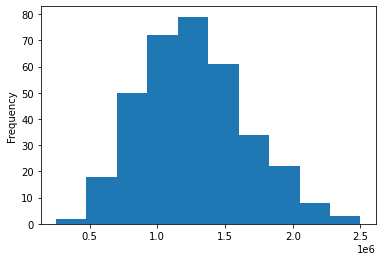

In [85]:
#To get visuals to best understand MAE
train_qa["CY SAP Monthly Sales"].plot.hist()

<AxesSubplot:ylabel='Frequency'>

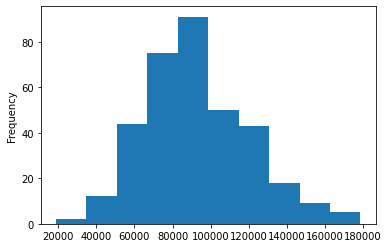

In [86]:
train_qa["CY SAP Monthly Tickets"].plot.hist()

# Write Functionized Rf

In [79]:
#This function selects the user specified target_response variable (sales or tickets) and returns the 
#response variables for train and test along with the baseline error metrics
def get_baseline(train, test, target_response = "Sales"):
    if target_response == "Sales":
        #First set the target vars
        y_train = train["CY SAP Monthly Sales"]
        y_test =  test["CY SAP Monthly Sales"]
    else:
        y_train = train["CY SAP Monthly Tickets"]
        y_test =  test["CY SAP Monthly Tickets"]
    
    #Drop reponse columns from train & test. ASSUMING THEY ARE THE LAST 3 COLS
    X_train = train.iloc[:,:-3]
    X_test = test.iloc[:,:-3]
    
    #Set error metrics
    mse_base = mean_squared_error(y_test, pd.Series(y_train.mean(), index=range(test.shape[0])))
    mae_base = mean_absolute_error(y_test, pd.Series(y_train.mean(), index=range(test.shape[0])))
    print(f'Baseline Metrics for {target_response}')
    print(f'Mean Squared Error: {mse_base}')
    print(f'Mean Absolute Error: {mae_base}')
    print(" ")
    
    return X_train, X_test, y_train, y_test, mse_base, mae_base

In [80]:
#This function trains your random forest via gridsearch or via user defined parameters & returns the trained random forest object.
def train_rf(train, y_train, gridsearch,n_estimators, max_depth, min_samples_leaf):
    if gridsearch:
        print("Beginning gridsearch ... ")
        clf = RandomForestRegressor(criterion="mae", n_jobs=-1)
        param_grid = {
                         'n_estimators': [100,200,300,500,750],
                         'max_depth': [2,3,4,5,6],
                         'min_samples_leaf': [1,2,3,5]
                     }
        start = time.time()
        grid_clf = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, refit=True)
        grid_clf.fit(train, y_train)
        end = time.time()
        print(f'Training took {round(end-start,2)} seconds.')
        print(f'Best Parameters after 10 fold CV gridsearch: {grid_clf.best_params_}')
        print(" ")
        return grid_clf
    else:
        print(f"No gridsearch. Training on: n_estimators = {n_estimators}, max_depth = {max_depth}, min_samples_leaf= {min_samples_leaf} ")
        print(" ")
        rf = RandomForestRegressor(criterion='mae', max_depth=max_depth, min_samples_leaf=min_samples_leaf,
                      n_estimators=n_estimators, n_jobs=-1)
        return rf

In [81]:
def get_error_metrics(rf, train, test, y_train, y_test, mse_base, mae_base):
    rf.fit(train, y_train)
    preds = rf.predict(train)
    mse_pred = mean_squared_error(y_train, preds)
    mae_pred = mean_absolute_error(y_train, preds)
    print("Training Error Reduction")
    print(f'Reduction in MSE: {1-mse_pred/mse_base}')
    print(f'Reduction in MAE: {1-mae_pred/mae_base}')
    print(" ")
    
    preds = rf.predict(test)
    mse_pred = mean_squared_error(y_test, preds)
    mae_pred = mean_absolute_error(y_test, preds)
    print('Test Error Metrics')
    print(f'Mean Squared Error: {mse_pred}')
    print(f'Mean Absolute Error: {mae_pred}')
    print(" ")
    print("Test Error Reduction")
    print(f'Reduction in MSE: {1-mse_pred/mse_base}')
    print(f'Reduction in MAE: {1-mae_pred/mae_base}')
    print(" ")
    
    return mse_pred, mae_pred

In [82]:
#Pass in train and test with no id at front. Have y vars attached as last 3 cols.

def random_forest(train, test, target_response = "Sales", gridsearch=False, 
                  n_estimators = 250, max_depth=3, min_samples_leaf = 3):
    
    train, test, y_train, y_test, mse_base, mae_base = get_baseline(train,test,target_response)
    rf = train_rf(train, y_train, gridsearch, n_estimators, max_depth, min_samples_leaf)
    mse, mae = get_error_metrics(rf, train, test, y_train, y_test, mse_base, mae_base)
    return rf
    

In [73]:
#random_forest(train_pop, test_pop, gridsearch=False, target_response = "Tickets",
              #n_estimators = 100, max_depth=3, min_samples_leaf = 1)

In [74]:
#random_forest(train_qa, test_qa, gridsearch=False, target_response = "Sales",
              #n_estimators = 300, max_depth=5, min_samples_leaf = 2)
#GS Sales n_estimators = 300, max_depth = 5, min_samples_leaf= 2 

In [76]:
rf = random_forest(train_sa, test_sa, gridsearch=True, target_response = "Sales",
              n_estimators = 150, max_depth=3, min_samples_leaf = 1)
#GS Sales n_estimators = 150, max_depth = 3, min_samples_leaf= 1 
#GS Tickets 'max_depth': 4, 'min_samples_leaf': 1, 'n_estimators': 200

In [85]:
#Top 150 most important features by rf importance.
pd.concat([pd.Series(train_sa.columns.values),pd.Series(rf.feature_importances_)],axis=1).sort_values(by=1, ascending=False)[0:150][0].values

NameError: name 'rf' is not defined

In [77]:
train_20rf = train_sa[['VOLUME INDEX 3mi', "EI03 - Men's Style 2mi",
       'EH01 - Mindfulness & Spirituality 3mi',
       'EB03 - LGBTQ Culture 3mi', 'EB07 - Farm Culture 2mi',
       'ED07 - Fueling for Fitness blockgrp', 'EI01 - Trend Trackers 3mi',
       'EE05 - Party Life 3mi', 'EC08 - Networking 3mi',
       'VOLUME INDEX 2mi', 'EA01 - Bookish blockgrp',
       'EI01 - Trend Trackers 0.25mi',
       'EH01 - Mindfulness & Spirituality 2mi',
       'EC02 - Happily Ever After 3mi', 'EH02 - Activism 1mi',
       'EA09 - Smoke Culture blockgrp', 'EF02 - Heartfelt Sharing 3mi',
       'VOLUME INDEX 1mi', 'EK02 - Fitness Obsession 0.25mi',
       'EB07 - Farm Culture 3mi', 'EH02 - Activism 2mi',
       'EF02 - Heartfelt Sharing 2mi', 'EB07 - Farm Culture 1mi',
       'EE05 - Party Life 2mi', "EI03 - Men's Style 3mi",
       'EE05 - Party Life blockgrp', 'EG05 - Hip Hop Culture 0.5mi',
       'EA03 - Green Thumb 0.25mi', 'VOLUME INDEX 0.25mi',
       'EA01 - Bookish 0.25mi', 'EH04 - Praise & Worship blockgrp',
       "EI03 - Men's Style blockgrp", 'EG04 - Sites to See 3mi',
       'ED05 - Asian Food & Culture 0.25mi',
       'EG05 - Hip Hop Culture 0.25mi', 'EG05 - Hip Hop Culture 3mi',
       'EC07 - Girl Squad 0.5mi', 'EF02 - Heartfelt Sharing blockgrp',
       'EE05 - Party Life 0.25mi', 'EC08 - Networking 0.25mi',
       'EG03 - Pieces of History 2mi', 'EF02 - Heartfelt Sharing 1mi',
       'ED09 - Hops & Brews blockgrp', 'EG04 - Sites to See 0.5mi',
       'EG03 - Pieces of History 1mi', 'EG03 - Pieces of History 3mi',
       'EJ03 - Humanitarian 3mi', 'EB07 - Farm Culture 0.25mi',
       'EK02 - Fitness Obsession blockgrp',
       'EF02 - Heartfelt Sharing 0.25mi',
       'EK05 - Functional Fitness blockgrp',
       'EC02 - Happily Ever After 2mi', 'EB03 - LGBTQ Culture blockgrp',
       'EI01 - Trend Trackers 0.5mi', 'EJ01 - Home & Leisure 0.25mi',
       'EC07 - Girl Squad 1mi', 'VOLUME INDEX 0.5mi',
       'ED04 - Whiskey Business blockgrp', 'EA09 - Smoke Culture 3mi',
       'EH06 - Civic Attentiveness 1mi', "EI03 - Men's Style 0.25mi",
       'EK05 - Functional Fitness 0.25mi', 'EC08 - Networking 2mi',
       'EA09 - Smoke Culture 0.5mi', 'EG03 - Pieces of History blockgrp',
       'EA09 - Smoke Culture 1mi', 'EH06 - Civic Attentiveness 2mi',
       'ED07 - Fueling for Fitness 3mi', 'EB02 - Nerd Culture 0.25mi',
       'EH06 - Civic Attentiveness 0.5mi', 'EF01 - Deep Emotions 2mi',
       'EB01 - Daily Grind 0.5mi', 'EF02 - Heartfelt Sharing 0.5mi',
       'EJ02 - Past Reflections 3mi', 'EH03 - Politically Engaged 3mi','CY POS Sales','CY SAP Monthly Sales', 'CY SAP Monthly Tickets']]
test_20rf = test_sa[['VOLUME INDEX 3mi', "EI03 - Men's Style 2mi",
       'EH01 - Mindfulness & Spirituality 3mi',
       'EB03 - LGBTQ Culture 3mi', 'EB07 - Farm Culture 2mi',
       'ED07 - Fueling for Fitness blockgrp', 'EI01 - Trend Trackers 3mi',
       'EE05 - Party Life 3mi', 'EC08 - Networking 3mi',
       'VOLUME INDEX 2mi', 'EA01 - Bookish blockgrp',
       'EI01 - Trend Trackers 0.25mi',
       'EH01 - Mindfulness & Spirituality 2mi',
       'EC02 - Happily Ever After 3mi', 'EH02 - Activism 1mi',
       'EA09 - Smoke Culture blockgrp', 'EF02 - Heartfelt Sharing 3mi',
       'VOLUME INDEX 1mi', 'EK02 - Fitness Obsession 0.25mi',
       'EB07 - Farm Culture 3mi', 'EH02 - Activism 2mi',
       'EF02 - Heartfelt Sharing 2mi', 'EB07 - Farm Culture 1mi',
       'EE05 - Party Life 2mi', "EI03 - Men's Style 3mi",
       'EE05 - Party Life blockgrp', 'EG05 - Hip Hop Culture 0.5mi',
       'EA03 - Green Thumb 0.25mi', 'VOLUME INDEX 0.25mi',
       'EA01 - Bookish 0.25mi', 'EH04 - Praise & Worship blockgrp',
       "EI03 - Men's Style blockgrp", 'EG04 - Sites to See 3mi',
       'ED05 - Asian Food & Culture 0.25mi',
       'EG05 - Hip Hop Culture 0.25mi', 'EG05 - Hip Hop Culture 3mi',
       'EC07 - Girl Squad 0.5mi', 'EF02 - Heartfelt Sharing blockgrp',
       'EE05 - Party Life 0.25mi', 'EC08 - Networking 0.25mi',
       'EG03 - Pieces of History 2mi', 'EF02 - Heartfelt Sharing 1mi',
       'ED09 - Hops & Brews blockgrp', 'EG04 - Sites to See 0.5mi',
       'EG03 - Pieces of History 1mi', 'EG03 - Pieces of History 3mi',
       'EJ03 - Humanitarian 3mi', 'EB07 - Farm Culture 0.25mi',
       'EK02 - Fitness Obsession blockgrp',
       'EF02 - Heartfelt Sharing 0.25mi',
       'EK05 - Functional Fitness blockgrp',
       'EC02 - Happily Ever After 2mi', 'EB03 - LGBTQ Culture blockgrp',
       'EI01 - Trend Trackers 0.5mi', 'EJ01 - Home & Leisure 0.25mi',
       'EC07 - Girl Squad 1mi', 'VOLUME INDEX 0.5mi',
       'ED04 - Whiskey Business blockgrp', 'EA09 - Smoke Culture 3mi',
       'EH06 - Civic Attentiveness 1mi', "EI03 - Men's Style 0.25mi",
       'EK05 - Functional Fitness 0.25mi', 'EC08 - Networking 2mi',
       'EA09 - Smoke Culture 0.5mi', 'EG03 - Pieces of History blockgrp',
       'EA09 - Smoke Culture 1mi', 'EH06 - Civic Attentiveness 2mi',
       'ED07 - Fueling for Fitness 3mi', 'EB02 - Nerd Culture 0.25mi',
       'EH06 - Civic Attentiveness 0.5mi', 'EF01 - Deep Emotions 2mi',
       'EB01 - Daily Grind 0.5mi', 'EF02 - Heartfelt Sharing 0.5mi',
       'EJ02 - Past Reflections 3mi', 'EH03 - Politically Engaged 3mi','CY POS Sales','CY SAP Monthly Sales', 'CY SAP Monthly Tickets']]

In [296]:
random_forest(train_sa3mi, test_sa3mi, gridsearch=True, target_response = "Sales",
              n_estimators = 300, max_depth=5, min_samples_leaf = 1)
#GS Sales n_estimators = 250, max_depth = 4, min_samples_leaf= 10 
#Tickets 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 300

Baseline Metrics for Tickets
Mean Squared Error: 839851400.7511384
Mean Absolute Error: 22075.93970700997
 
No gridsearch. Training on: n_estimators = 300, max_depth = 5, min_samples_leaf= 1 
 
Training Error Reduction
Reduction in MSE: 0.5646410604319736
Reduction in MAE: 0.3419587997904744
 
Test Error Metrics
Mean Squared Error: 765287411.7103888
Mean Absolute Error: 21747.909237089203
 
Test Error Reduction
Reduction in MSE: 0.08878235956272962
Reduction in MAE: 0.014859184898779354
 


RandomForestRegressor(criterion='mae', max_depth=5, n_estimators=300, n_jobs=-1)

In [86]:
#random_forest(train_merge, test_merge, gridsearch=False, target_response = "Sales",
              #n_estimators = 500, max_depth=5, min_samples_leaf = 1)
#GS Sales n_estimators = 500, max_depth = 5, min_samples_leaf= 1 
#GS tickets 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 200

# Now GridSearch for top 20 vars & all radii sales

In [84]:
random_forest(train_20rf, test_20rf, gridsearch=True,  target_response = "Sales",
              n_estimators = 300, max_depth=5, min_samples_leaf = 1)
#GS for sales top 20 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 200
#For Sales top 76 {'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 300}
#GS for tickets top 150 max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 200

Baseline Metrics for Sales
Mean Squared Error: 201133246044.32974
Mean Absolute Error: 353716.2703747125
 
No gridsearch. Training on: n_estimators = 300, max_depth = 5, min_samples_leaf= 1 
 
Training Error Reduction
Reduction in MSE: 0.6944101103992703
Reduction in MAE: 0.4449184926027595
 
Test Error Metrics
Mean Squared Error: 179896811140.26297
Mean Absolute Error: 333880.88906161976
 
Test Error Reduction
Reduction in MSE: 0.10558391176855098
Reduction in MAE: 0.05607709617677448
 


RandomForestRegressor(criterion='mae', max_depth=5, n_estimators=300, n_jobs=-1)

In [256]:
random_forest(train_sa_blockgrp, test_sa_blockgrp, gridsearch=True,  target_response = "Sales",
              n_estimators = 100, max_depth=5, min_samples_leaf = 1)
#GS Sales n_estimators = 100, max_depth = 5, min_samples_leaf= 1
#Ticekts GS 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 200

Baseline Metrics for Sales
Mean Squared Error: 201133246044.32974
Mean Absolute Error: 353716.2703747125
 
No gridsearch. Training on: n_estimators = 100, max_depth = 5, min_samples_leaf= 1 
 
Training Error Reduction
Reduction in MSE: 0.6409899503294005
Reduction in MAE: 0.39666565508325136
 
Test Error Metrics
Mean Squared Error: 199474195733.6398
Mean Absolute Error: 345092.6503080986
 
Test Error Reduction
Reduction in MSE: 0.008248513576538663
Reduction in MAE: 0.02438004917749015
 


RandomForestRegressor(criterion='mae', max_depth=5, n_jobs=-1)

In [260]:
random_forest(train_sa_qmi, test_sa_qmi, gridsearch=True, target_response = "Sales",
              n_estimators = 300, max_depth=4, min_samples_leaf = 1)
#GS Sales 'max_depth': 4, 'min_samples_leaf': 1, 'n_estimators': 300
#Ticks 'max_depth': 4, 'min_samples_leaf': 1, 'n_estimators': 100

Baseline Metrics for Sales
Mean Squared Error: 201133246044.32974
Mean Absolute Error: 353716.2703747125
 
No gridsearch. Training on: n_estimators = 300, max_depth = 4, min_samples_leaf= 1 
 
Training Error Reduction
Reduction in MSE: 0.5694595250586917
Reduction in MAE: 0.3436838107251914
 
Test Error Metrics
Mean Squared Error: 193168969433.8878
Mean Absolute Error: 347434.1262605634
 
Test Error Reduction
Reduction in MSE: 0.039597017236457366
Reduction in MAE: 0.01776040470938489
 


RandomForestRegressor(criterion='mae', max_depth=4, n_estimators=300, n_jobs=-1)

In [263]:
random_forest(train_sa_hmi, test_sa_hmi, gridsearch=True,target_response = "Sales",
              n_estimators = 200, max_depth=5, min_samples_leaf = 1)
#GS Sales 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 200

Baseline Metrics for Sales
Mean Squared Error: 201133246044.32974
Mean Absolute Error: 353716.2703747125
 
No gridsearch. Training on: n_estimators = 200, max_depth = 5, min_samples_leaf= 1 
 
Training Error Reduction
Reduction in MSE: 0.6503040724628328
Reduction in MAE: 0.4057372991906686
 
Test Error Metrics
Mean Squared Error: 192342637689.0741
Mean Absolute Error: 345068.1781028169
 
Test Error Reduction
Reduction in MSE: 0.04370539693531417
Reduction in MAE: 0.02444923515317554
 


RandomForestRegressor(criterion='mae', max_depth=5, n_estimators=200, n_jobs=-1)

In [267]:
random_forest(train_sa_1mi, test_sa_1mi, gridsearch=True, target_response = "Sales",
              n_estimators = 500, max_depth=5, min_samples_leaf = 1)
#GS Sales max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 500
#tickets 'max_depth': 4, 'min_samples_leaf': 1, 'n_estimators': 200

Baseline Metrics for Sales
Mean Squared Error: 201133246044.32974
Mean Absolute Error: 353716.2703747125
 
No gridsearch. Training on: n_estimators = 500, max_depth = 5, min_samples_leaf= 1 
 
Training Error Reduction
Reduction in MSE: 0.6591048284557948
Reduction in MAE: 0.4113297964531565
 
Test Error Metrics
Mean Squared Error: 179594297165.0579
Mean Absolute Error: 336157.91969683097
 
Test Error Reduction
Reduction in MSE: 0.10708795936463267
Reduction in MAE: 0.0496396466560074
 


RandomForestRegressor(criterion='mae', max_depth=5, n_estimators=500, n_jobs=-1)

In [271]:
random_forest(train_sa_2mi, test_sa_2mi, gridsearch=True, target_response = "Sales",
              n_estimators = 500, max_depth=4, min_samples_leaf = 1)
#GS Sales n_estimators = 500, max_depth = 4, min_samples_leaf= 1 
#ticks 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 100

Baseline Metrics for Sales
Mean Squared Error: 201133246044.32974
Mean Absolute Error: 353716.2703747125
 
No gridsearch. Training on: n_estimators = 500, max_depth = 4, min_samples_leaf= 1 
 
Training Error Reduction
Reduction in MSE: 0.6009320419449798
Reduction in MAE: 0.3738383265818238
 
Test Error Metrics
Mean Squared Error: 173399864273.15247
Mean Absolute Error: 329562.5538779577
 
Test Error Reduction
Reduction in MSE: 0.13788561720455128
Reduction in MAE: 0.06828556817917175
 


RandomForestRegressor(criterion='mae', max_depth=4, n_estimators=500, n_jobs=-1)

In [274]:
random_forest(train_sa_3mi, test_sa_3mi, gridsearch=True,target_response = "Sales",
              n_estimators = 300, max_depth=5, min_samples_leaf = 1)
#GS Sales n_estimators = 300, max_depth = 5, min_samples_leaf= 1 

Baseline Metrics for Sales
Mean Squared Error: 201133246044.32974
Mean Absolute Error: 353716.2703747125
 
No gridsearch. Training on: n_estimators = 300, max_depth = 5, min_samples_leaf= 1 
 
Training Error Reduction
Reduction in MSE: 0.6975645294731937
Reduction in MAE: 0.44851942229529684
 
Test Error Metrics
Mean Squared Error: 170313294672.4064
Mean Absolute Error: 327553.9606150235
 
Test Error Reduction
Reduction in MSE: 0.15323151183634065
Reduction in MAE: 0.07396411177799
 


RandomForestRegressor(criterion='mae', max_depth=5, n_estimators=300, n_jobs=-1)

# Tickets